In [1]:
# https://wikidocs.net/233348
# https://medium.com/the-modern-scientist/prompt-engineering-classification-of-techniques-and-prompt-tuning-6d4247b9b64c

In [2]:
# pip install langchain

In [3]:
# pip install -U langchain-ollama

In [4]:
# pip install langchain_teddynote
#  ollama create llama-3.1-70b-instruct-lorablated.Q4_K_M:latest -f Modelfile
# ollama create llama-3.1-70b-instruct-lorablated.Q4_K_M:latest -f Modelfile_73

In [5]:

import warnings
import langchain
from langchain_ollama.llms import OllamaLLM
from langchain_core.prompts.few_shot import FewShotPromptTemplate
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
import pandas as pd
import numpy as np
from tqdm import tqdm
import time

warnings.filterwarnings("ignore", category=DeprecationWarning)
# https://wikidocs.net/233348
# https://rfriend.tistory.com/839

In [6]:
# df = pd.read_csv('../../data/part_one_q_output.csv', index_col = 0)
# df = pd.read_csv('../../data/part_one_q_output_code_y.csv', index_col = 0)
df = pd.read_csv('../../../data/q_output_241201.csv', index_col = 0)


In [7]:
df['question'][0]

"<Title>Why is this gunicorn, flask, bokeh application not running with 4 workers?</Title>. <Question>I am learning to use gunicorn, flask and bokeh.\nI am trying to set up a little example to use a bokeh app with multiuser. I am working on a debian system on an AWS server with a static IP. I used the example from git and edited it in the way I think it should work. I got it to run with this command:\n\n\n\n\nBut when I change the workers to 4 and the binded port from 5006 to 0 (flaskapp.py), I get this error in the browser console:\n\n:34163/bkapp/autoload.js?bokeh-autoload-element=4755&bokeh-app-path=/bkapp&bokeh-absolute-url=http://35.XXX.XXX.153:34163/bkapp:1          Failed to load resource: net::ERR_CONNECTION_TIMED_OUT\n\nCan someone tell me, why I get this error?\nHere is the relevant code:\nflaskapp.py\n\n\n\n\nwsgi.py\n\n\n\n\nembed.html\n\n\n\n\n</Question>  Let's think through the difficulty of question carefully, step by step."

In [8]:
llm = OllamaLLM(model="llama-3.1-70b-instruct-lorablated.Q4_K_M:latest")
parser = StrOutputParser()
# llm = OllamaLLM(model="llama3.1:70b")


In [9]:
df.shape[0]

93

In [10]:
df_plot = df['answer'].value_counts().to_frame().reset_index()

In [11]:
df_plot.loc[df_plot['answer']=='Difficulty Level : Basic', 'count'].values[0]

27

In [12]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(3)
di_dict = {}
for di in ['Difficulty Level : Basic', 'Difficulty Level : Intermediate', 'Difficulty Level : Advanced']:
    di_dict[di] = df_plot.loc[df_plot['answer']==di, 'count'].values[0]
print(list(di_dict.values()))

[27, 49, 11]


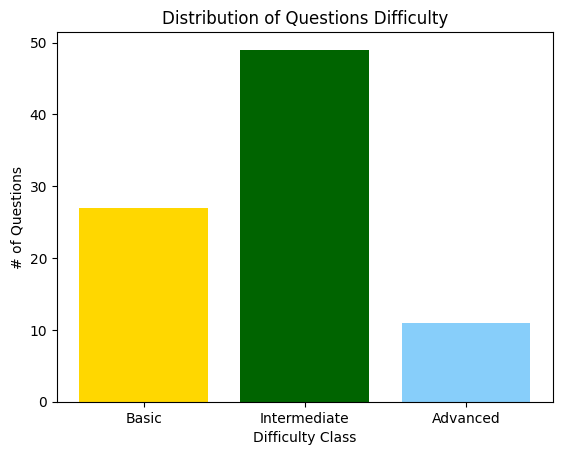

In [13]:
plt.bar(  x
        , list(di_dict.values())
        , color = ['gold', 'darkgreen', 'lightskyblue']
        , width = 0.8
        , label = list(di_dict.keys()))
plt.xticks(x, [x.replace('Difficulty Level : ', '') for x in list(di_dict.keys())] )
# plt.legend()

plt.ylabel('# of Questions')
plt.xlabel('Difficulty Class')
# plt.xticks(rotation = 45)
plt.title('Distribution of Questions Difficulty')

plt.show()


In [14]:
diff_idx = {x : list(df[df['answer']==x].index) for x in list(di_dict.keys())}

In [15]:
diff_s_idx = {}
for key, value in diff_idx.items():
    print(key, value)
    dic_col = f'{key}_sample_idx'
    diff_population = value
    np.random.seed(11)
    diff_s_idx[dic_col] = np.random.choice(diff_population, size=3, replace=False)

Difficulty Level : Basic [2, 3, 4, 8, 12, 18, 19, 20, 25, 26, 35, 37, 40, 42, 47, 51, 52, 62, 67, 69, 71, 80, 82, 85, 87, 89, 90]
Difficulty Level : Intermediate [1, 5, 6, 7, 9, 10, 11, 13, 14, 15, 21, 22, 23, 24, 28, 29, 30, 32, 33, 34, 38, 39, 41, 43, 45, 46, 49, 50, 53, 54, 55, 56, 57, 58, 59, 60, 63, 64, 66, 68, 72, 73, 74, 75, 78, 79, 84, 86, 88]
Difficulty Level : Advanced [0, 16, 31, 36, 48, 61, 65, 76, 81, 91, 92]


In [16]:
diff_s_idx

{'Difficulty Level : Basic_sample_idx': array([35, 69, 19]),
 'Difficulty Level : Intermediate_sample_idx': array([ 6, 74, 63]),
 'Difficulty Level : Advanced_sample_idx': array([65, 92, 31])}

In [17]:
from itertools import chain

fewshot_q_id = list(chain.from_iterable(diff_s_idx.values()))


In [18]:
eval_q_id =np.setdiff1d(list(df.index), fewshot_q_id)

In [19]:
examples = []
for idx in fewshot_q_id:
# for idx in [19]:
    temp_dict = {"question" : str(df.loc[idx, 'question']),
                 "answer"   : str(df.loc[idx, 'answer'])}
    examples.append(temp_dict)

In [20]:
example_prompt = PromptTemplate.from_template(
    "**Question**\n{question}\n**Answer**\n{answer}"
)

print(example_prompt.format(**examples[0]))

**Question**
<Title>Merge dictionary without duplicating key and make empty string in case different key</Title>. <Question>suppose I have a list




and I want to make a function which
get two input dictionary and merge input
for example
merge A[0], A[1], and A[2]
output is




</Question>  Let's think through the difficulty of question carefully, step by step.
**Answer**
Difficulty Level : Basic


In [21]:
prompt = FewShotPromptTemplate(
    examples=examples,
    example_prompt=example_prompt,
    suffix="**Question**\n{question}\n**Answer**",
    input_variables=["question"],
)

In [22]:
eval_result = pd.DataFrame(columns = ['id', 'result'])
for idx in tqdm(eval_q_id):
    question = df.loc[idx, 'question']
    print(question)
    final_prompt = prompt.format(question=question)
    chain = prompt | llm | parser

    # chain 호출
    response = chain.invoke({"question": question})
    tmp_dict = {'id' : df.loc[idx, 'id']
                ,'result' : response}
    eval_result = pd.concat([eval_result, pd.DataFrame([tmp_dict])], ignore_index=True)

  0%|          | 0/84 [00:00<?, ?it/s]

<Title>Why is this gunicorn, flask, bokeh application not running with 4 workers?</Title>. <Question>I am learning to use gunicorn, flask and bokeh.
I am trying to set up a little example to use a bokeh app with multiuser. I am working on a debian system on an AWS server with a static IP. I used the example from git and edited it in the way I think it should work. I got it to run with this command:




But when I change the workers to 4 and the binded port from 5006 to 0 (flaskapp.py), I get this error in the browser console:

:34163/bkapp/autoload.js?bokeh-autoload-element=4755&bokeh-app-path=/bkapp&bokeh-absolute-url=http://35.XXX.XXX.153:34163/bkapp:1          Failed to load resource: net::ERR_CONNECTION_TIMED_OUT

Can someone tell me, why I get this error?
Here is the relevant code:
flaskapp.py




wsgi.py




embed.html




</Question>  Let's think through the difficulty of question carefully, step by step.


  1%|          | 1/84 [00:51<1:10:41, 51.10s/it]

<Title>Why joblib is not recommended when saving keras model?</Title>. <Question>According to this keras documentation, pickle is not recommended to save keras mode, and since joblib.dump() and joblib.load() are based on the Python pickle serialization model, joblib is also not recommended to save keras model. What is the reason for that ?
</Question>  Let's think through the difficulty of question carefully, step by step.


  1%|          | 1/84 [00:52<1:13:12, 52.92s/it]


KeyboardInterrupt: 

In [ ]:
result_df = pd.merge(df,eval_result, on = 'id' )

In [ ]:
result_df.head()

In [ ]:
result_df['answer_diff_class'] = [x[1] for x in result_df['answer'].str.split(r"[|:]+")]


In [ ]:
result_df['result_diff_class']  = [x[1] for x in result_df['result'].str.split(r"[|:]+")]


In [ ]:
result_df.head()

In [ ]:
result_df.head(10)

In [ ]:
result_df['answer_diff_class'] = result_df['answer_diff_class'].str.strip()
result_df['result_diff_class'] = result_df['result_diff_class'].str.strip()

In [ ]:
result_df['answer_diff_class_0'] = [x[0] for x in result_df['answer_diff_class'].str.split(' ')]
result_df['result_diff_class_0'] = [x[0] for x in result_df['result_diff_class'].str.split(' ')]

In [ ]:
result_df['equal_yn'] = np.where(result_df['answer_diff_class_0']==result_df['result_diff_class_0'], 1, 0)

In [ ]:
acc = (result_df['equal_yn'].sum()/result_df.shape[0])*100
print(acc)

In [ ]:
result_df[result_df['equal_yn']==0]

In [ ]:
pd.DataFrame(examples).to_csv('chk.csv')